### Optimal CP Detection

Implements Levy-Leduc Code to determine optimal number of changepoints across a candidate set specifically with
- Dynamic Programming Recursion
- Model Selection vis Generalized Cross Validation Score (El. of Stat Learning pg 325)
- Continuity Correction using Linear Splines


In [1]:
import numpy as np
import sys

sys.path.append("../")
from scipy.interpolate import LSQUnivariateSpline
import matplotlib.pyplot as plt

from evaluation_metrics.loss_functions import compute_error
from model_selection.partition import best_fit_polynomial, map_intervals
from trend_filtering.tf_constants import get_simulation_constants

Map changepoint indices to interval partitions

In [2]:
def map_intervals(Y,indices):
    """ Maps the indices of the candidate changepoints to a dictionary of intervals
    """
    intervals={}
    for i in range(len(indices)-1):
        intervals[i]=([indices[i],indices[i+1]])
   
    return intervals


Fit polynomial order k on each interval (OLS)

In [3]:

def best_fit_polynomial(Y,interval,order=1):
    """ Fits a polynomial of order k to the data Y across a given interval
    """
    # partitions x and y of interval 
    y=Y[interval[0]:interval[1]]
    x_range=np.arange(interval[0],interval[1],1)

    # fit polynomial of order k to data
    poly_coef=np.polyfit(x_range,y,order)
    polynomial=poly_coef.dot(np.vstack([x_range**i for i in range(order,-1,-1)]))
    
    # mean squared error of fit
    mse=np.mean((y-polynomial)**2)

    return mse

Compute cost matrix for merged intervals

In [4]:
def compute_J(Y,indices,cp_mappings,order):
    """ Evaluate cost matrix between each nested pair of changepoints
    """
    
    k=len(indices)-1
    mapping_indices=np.arange(k)

    # initialize cost matrix
    cost_matrix=np.zeros((k,k))
    
    # evaluate cost matrix, looping over nested pairs of merged intervals
    for i in range(len(mapping_indices)):
        for j in range(i,len(mapping_indices)):
          
            interval=[cp_mappings[i][0],cp_mappings[j][1]]
            cost_matrix[i,j]=best_fit_polynomial(Y,interval,order=order)

    return cost_matrix

Compute recursion matrix for optimal cost and location

In [5]:
def compute_V(cost_matrix,K_max,indices):
    """ Computes the optimal cost and changepoint locations
    """
   
    k=len(indices)-1
    
    # initialize optimal cost and optimal location matrices
    optimal_cost=np.zeros((K_max+1,k))
    optimal_loc=np.zeros((K_max,k))
    
    
    # no changepoints; best RSE is the sum of squared errors on interval
    for i in range(k):
        optimal_cost[0,i]=cost_matrix[0,i]
  
    # loop over number of possible changepoints calculating optimal cost and location of indices 
    # utilizes dynamic programming structure to build solution from subproblems solution 
    for k_i in range(1,K_max+1):
        for j in range(k_i+1,k+1):
      
            optimal_cost[k_i,j-1]=np.min(optimal_cost[k_i-1,k_i-1:j-1]+cost_matrix[k_i:j,j-1])
            ind=np.argmin(optimal_cost[k_i-1,k_i-1:j-1]+cost_matrix[k_i:j,j-1])
            optimal_loc[k_i-1,j-1]=ind+k_i-1
 
    return optimal_loc

Determine optimal segmentation for each fixed changepoint

In [6]:
def optimal_segmentation(optimal_loc,indices,K_max):
    """ Computes the optimal segmentation based on recursive RSE
    """
    
    all_loc=optimal_loc.copy()
    k=len(indices)-1

    # dictionary keyed by potential cp, values are cps that are optimal for that k_i
    total_loc={}

    for k_i in range(1,K_max+1):
        total_loc[k_i-1]=np.zeros(k_i)
        total_loc[k_i-1][k_i-1]=all_loc[k_i-1,k-1]
        for i in range(k_i-1,0,-1):
            total_loc[k_i-1][i-1]=all_loc[i-1,int(total_loc[k_i-1][i])]

    return total_loc

Convert indices of optimal cp to original cp

In [7]:
def convert_observed_cp(optimal_segment,indices):
    """Converts the optimal changepoints to the observed indices
    """
    all_segments=optimal_segment.copy()
    
    # keys by number of points 
    for i in range(len(all_segments)):
        indices_dict=dict(zip([i for i in range(0,len(indices))],indices))
        
        all_segments[i]=[indices_dict[int(i)+1] for i in all_segments[i]]
    all_segments={i+1:all_segments[i] for i in range(len(all_segments))}
    # include case where zero changepoints are optimal
    all_segments[0]=[0]
    return all_segments

Management class for partition recursion

In [8]:

def partition_solver(Y,indices,K_max,k=1):
    """ Management function to determine optimal changepoints per fixed size
    """

    if K_max>len(indices):
        print("K_max must be less than or equal to the number of candidate changepoints")
        K_max=len(indices)

    indices=np.unique(np.concatenate([[0],indices,[len(Y)]]))
    print("Indices are {}".format(indices))

    # map the indices to the intervals of the data
    cp_mappings=map_intervals(Y,indices)
    
    # Initialize cost matrix
    cost_matrix=compute_J(Y,indices,cp_mappings,k)

    # Compute optimal cost and changepoint locations
    optimal_loc=compute_V(cost_matrix,K_max,indices)
    
    # Compute optimal segmentation
    optimal_segment=optimal_segmentation(optimal_loc,indices,K_max)

    optimal_indices=convert_observed_cp(optimal_segment,indices)

    return optimal_indices


### Test Data and Simulation

Given true changepoints; generate brownian motion in between

Populate candidate set with true and fake changepoints

Evaluate performance 

In [9]:
def test_dp():
    """ Prep dataset to test dynamic programming recursion
    """
    n=250
    k=5
    x=np.arange(0,n,1)
    y=np.empty(n)

    sample_variance=0.5
    
    n1,n2,n3,n4,n5=np.arange(0,n,n/k).astype(int)
    
    def generate_noise(samples,sample_variance):
        return np.random.normal(scale=sample_variance,size=n)
    
    y[:n2]=0.1*x[:n2]+2
    y[n2:n3]=-0.05*x[n2:n3]+9.5
    y[n3:n4]=0.05*x[n3:n4]-0.5

    y[n4:n5]=-0.05*x[n4:n5]+14.5
    y[n5:]=0.25*x[n5:]-45.5

    true_cp=np.array([n2,n3,n4,n5])
    noisy_cp=np.array([35,45,n2,75,98,n3,125,130,135,141,n4,167,n5,210])
    
    return x,y+0.5*generate_noise(n,sample_variance),noisy_cp,true_cp

### Test Cases

1. Pass in K_max=n where n is number of changepoints. Optimal solution for k_i=K_max should be original CP set

In [10]:
x,y,noisy_cp,true_cp=test_dp()
n=len(noisy_cp)

optimal_indices=partition_solver(y,noisy_cp,K_max=n,k=1)
optimal_indices

Indices are [  0  35  45  50  75  98 100 125 130 135 141 150 167 200 210 250]


{1: [210],
 2: [35, 210],
 3: [45, 125, 200],
 4: [50, 98, 150, 200],
 5: [50, 98, 100, 150, 200],
 6: [45, 50, 98, 100, 150, 200],
 7: [45, 50, 98, 100, 141, 150, 200],
 8: [35, 45, 50, 98, 100, 141, 150, 200],
 9: [45, 50, 98, 100, 125, 130, 141, 150, 200],
 10: [35, 45, 50, 98, 100, 125, 130, 141, 150, 200],
 11: [35, 45, 50, 98, 100, 125, 130, 135, 141, 150, 200],
 12: [35, 45, 50, 75, 98, 100, 125, 130, 135, 141, 150, 200],
 13: [35, 45, 50, 75, 98, 100, 125, 130, 135, 141, 150, 167, 200],
 14: [35, 45, 50, 75, 98, 100, 125, 130, 135, 141, 150, 167, 200, 210],
 0: [0]}

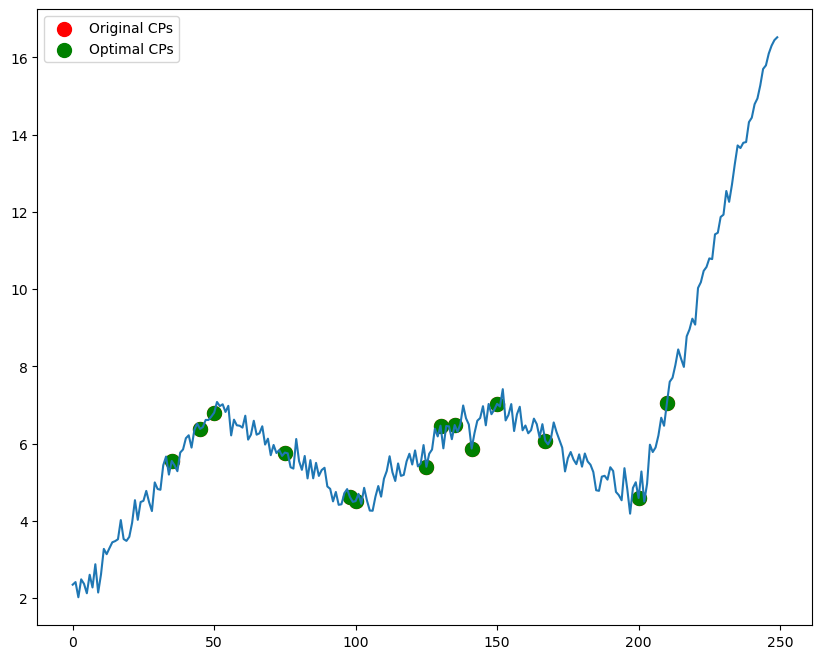

In [11]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
ax.plot(x,y)
ax.scatter(x[noisy_cp],y[noisy_cp],c='r',s=100,label='Original CPs')
ax.scatter(x[optimal_indices[n]],y[optimal_indices[n]],c='g',s=100,label='Optimal CPs')
ax.legend()

### Model Selection

Performs model selection via minimization of GCV Score

Returns mse and gcv of each fixed cp; sorted increasing order

In [12]:
def generalized_cross_validation(Y, optimal_indices, order, true_knots, verbose=False):
    """Determines optimal number of changepoints based on generalized cross validation"""

    # init dictionaries to store the results for optimal k cp
    model_mse = dict.fromkeys(optimal_indices.keys(), 0)
    biased_cv_epe = dict.fromkeys(optimal_indices.keys(), 0)
    gcv = dict.fromkeys(optimal_indices.keys(), 0)

    # compute the mse of the true model
    temp_cps = np.unique(np.concatenate([[0], true_knots, [len(Y)]])).astype(int)

    fixed_intervals = map_intervals(Y, temp_cps)

    true_mse = 0
    # compute the sum of squared errors of best fitted polynomial each interval

    for inter in list(fixed_intervals.values()):
        mse = best_fit_polynomial(Y, inter, order=order)
        true_mse += mse

    # compute the mse of the model for each k
    for k_i, cps in optimal_indices.items():

        # pad cps
        temp_cps = np.unique(np.concatenate([[0], cps, [len(Y)]])).astype(int)

        fixed_intervals = map_intervals(Y, temp_cps)

        fixed_mse = 0
        # compute the sum of squared errors of best fitted polynomial each interval

        for inter in list(fixed_intervals.values()):
            mse = best_fit_polynomial(Y, inter, order=order)
            fixed_mse += mse
        model_mse[k_i] = fixed_mse

    # max deviation between candidate prior and true prior
    # here we use the haussdorf distance
    max_deviation = 0
    max_deviation_dict = {}
    for k_i, cps in optimal_indices.items():
        deviation = compute_error(np.array(true_knots), np.array(cps), type="hausdorff")
        max_deviation_dict[k_i] = deviation

        if deviation > max_deviation:
            max_deviation = deviation
            max_deviation_set = cps

    max_distance = compute_error(np.array(true_knots), np.array(max_deviation_set), type="hausdorff")
    cv_bias = get_simulation_constants()["cv_bias"]

    # compute the biased cross validation error for each k
    for k_i, mse in model_mse.items():

        # perhaps instead of using the max deviation, we use the number of parameters as a measure of simplicity
        current_distance = max_deviation_dict[k_i]

        relative_accuracy = cv_bias * (mse / true_mse)
        in_sample_simplicity = (1 - cv_bias) * (current_distance / max_distance) ** 2

        biased_cv_epe[k_i] = relative_accuracy + in_sample_simplicity

        # compute effective number of parameters;
        # this is order + 1 for each interval (# of knots + 1)

        eff_param = (k_i + 1) * (order + 1)

        gcv[k_i] = mse / (len(Y) - eff_param) ** 2

    sorted_gcv = sorted(gcv.items(), key=lambda x: x[1])

    # if optimal cp is first index; no cp are found
    if sorted_gcv[0][0] == 0:
        if verbose:
            print("No changepoints found")

    return sorted_gcv



In [13]:
generalized_cross_validation(y, optimal_indices, order=1, true_knots=true_cp, verbose=True)

[(4, 5.301165917449923e-06),
 (5, 5.4240847469962325e-06),
 (6, 5.644164089157583e-06),
 (7, 6.385622147917211e-06),
 (8, 7.213451431699701e-06),
 (9, 7.96572897541184e-06),
 (10, 8.848737040776705e-06),
 (11, 9.876629356220525e-06),
 (12, 1.0992046934148778e-05),
 (3, 1.1006356608317578e-05),
 (2, 1.1402612831232458e-05),
 (13, 1.2464074361394405e-05),
 (14, 1.436335168436891e-05),
 (1, 1.8445849277414986e-05),
 (0, 7.104873582112616e-05)]

In [14]:
optimal_indices

{1: [210],
 2: [35, 210],
 3: [45, 125, 200],
 4: [50, 98, 150, 200],
 5: [50, 98, 100, 150, 200],
 6: [45, 50, 98, 100, 150, 200],
 7: [45, 50, 98, 100, 141, 150, 200],
 8: [35, 45, 50, 98, 100, 141, 150, 200],
 9: [45, 50, 98, 100, 125, 130, 141, 150, 200],
 10: [35, 45, 50, 98, 100, 125, 130, 141, 150, 200],
 11: [35, 45, 50, 98, 100, 125, 130, 135, 141, 150, 200],
 12: [35, 45, 50, 75, 98, 100, 125, 130, 135, 141, 150, 200],
 13: [35, 45, 50, 75, 98, 100, 125, 130, 135, 141, 150, 167, 200],
 14: [35, 45, 50, 75, 98, 100, 125, 130, 135, 141, 150, 167, 200, 210],
 0: [0]}

### Optimal Selected CP

Selected model with minimized gcv score

Model Estimates for optimal cp are exactly true cp from candidate set

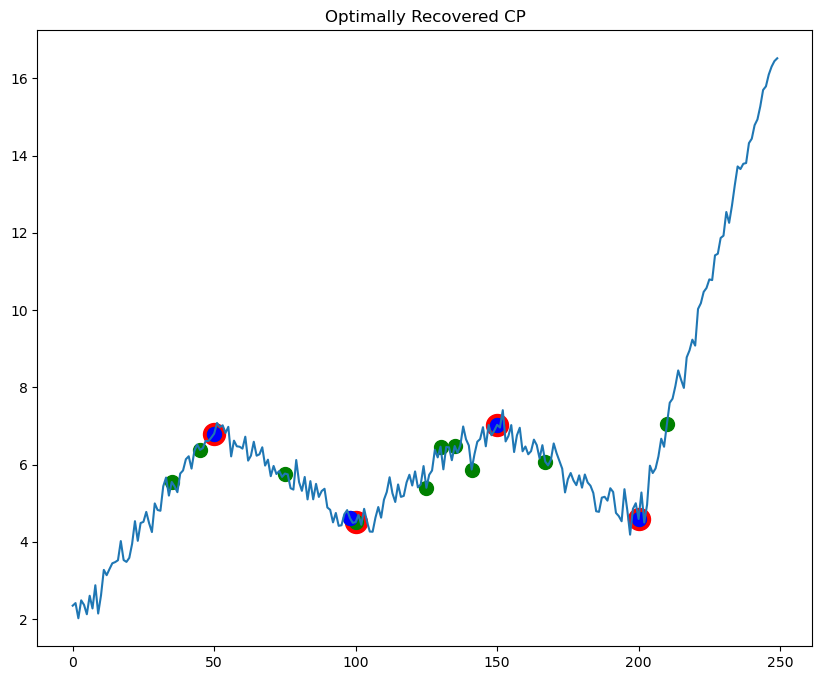

In [15]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
ax.set_title("Optimally Recovered CP")
ax.plot(x,y)
ax.scatter(x[true_cp],y[true_cp],c='r',s=250,label='True CPs')
ax.scatter(x[noisy_cp],y[noisy_cp],c='g',s=100,label='Noisy CPs')
ax.scatter(x[optimal_indices[4]],y[optimal_indices[4]],c='b',s=100,label='Optimally Selected CPs')

### Fit Linear Spline with optimal changepoints as our explicit knots
Interpretation is this is the best piecewise linear continuous estimator 

In [16]:
def fit_linear_spline(y,optimal_cp,order=1):
    """ Fits a linear spline to the data using the optimal changepoints
    """
    
    x=np.arange(0,len(y),1)

    spline=LSQUnivariateSpline(x,y,t=optimal_cp,k=order)

    return spline(x)

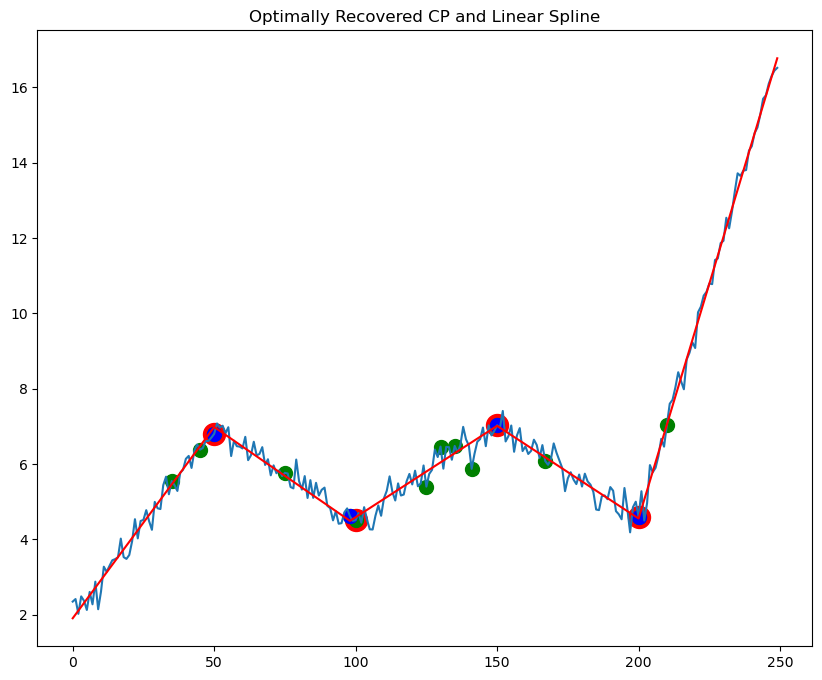

In [17]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
ax.set_title("Optimally Recovered CP and Linear Spline")
ax.plot(x,y)
ax.plot(x,fit_linear_spline(y,optimal_indices[4],order=1),c='r',label='Linear Spline')
ax.scatter(x[true_cp],y[true_cp],c='r',s=250,label='True CPs')
ax.scatter(x[noisy_cp],y[noisy_cp],c='g',s=100,label='Noisy CPs')
ax.scatter(x[optimal_indices[4]],y[optimal_indices[4]],c='b',s=100,label='Optimally Selected CPs')

### Results

Changepoints within optimal model match true changepoints exactly

In [18]:
true_cp

array([ 50, 100, 150, 200])

In [19]:
optimal_indices[4]

[50, 98, 150, 200]